In [338]:
!pwd

/Users/mike/Documents/Project/FedWeight/FedWeight_eICU/notebook/etm


In [339]:
import os

# Change the directory to your scratch folder
# os.chdir('/scratch/mikezhu/fed_weight_jupyter/notebook')
# os.chdir('/scratch/mikezhu/fed_weight_jupyter/notebook')

In [340]:
!pwd

/Users/mike/Documents/Project/FedWeight/FedWeight_eICU/notebook/etm


In [341]:
import torch
import numpy as np
import random

# Set the seed for reproducibility
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

In [342]:
import pandas as pd

icd_data = pd.read_csv("../../data/eicu_mimic_patient_diagnosis.csv")
icd_code_names = icd_data.columns[4:]

/var/folders/wd/d0j10lq906x4lfc0bphzybd80000gn/T/ipykernel_42311/1336925752.py:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  icd_data = pd.read_csv("../../data/eicu_mimic_patient_diagnosis.csv")


In [343]:
icd_data.shape

(156802, 841)

In [344]:
icd_code_names

Index(['3', '4', '5', '7', '8', '9', '11', '12', '13', '14',
       ...
       '989', '990', '991', '992', '994', '995', '996', '997', '998', '999'],
      dtype='object', length=837)

In [345]:
'247' in icd_code_names

False

In [346]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [347]:
mimic_data = icd_data[icd_data["hospitalid"] == 2001]
eicu_data = icd_data[icd_data["hospitalid"] == 1001]

mimic_icds = mimic_data.iloc[:, 4:].to_numpy()
eicu_icds = eicu_data.iloc[:, 4:].to_numpy()

In [348]:
t_hidden_size = 512
rho_size = 512
num_topics = 32
enc_drop = 0.2

In [349]:
import torch.nn as nn
import torch.nn.functional as F

class ETM(nn.Module):
    def __init__(self, num_topics, vocab_size, t_hidden_size, rho_size, enc_drop=0.5):
        super(ETM, self).__init__()

        ## define hyperparameters
        self.num_topics = num_topics
        self.vocab_size = vocab_size
        self.rho_size = rho_size
        self.enc_drop = enc_drop
        self.t_drop = nn.Dropout(enc_drop)

        ## define the word embedding matrix \rho
        self.rho = nn.Linear(rho_size, vocab_size, bias=False)

        # with torch.no_grad():
        #     self.rho.weight = nn.Parameter(pretrained_rho_tensor.T)
        #     self.rho.weight.requires_grad = False

        ## define the matrix containing the topic embeddings
        self.alphas = nn.Linear(rho_size, num_topics, bias=False)

        ## define variational distribution for \theta_{1:D} via amortizartion
        # print(vocab_size, " THE Vocabulary size is here ")
        self.q_theta = nn.Sequential(
                nn.Linear(vocab_size, t_hidden_size),
                nn.ReLU(),
            )

        self.mu_q_theta = nn.Linear(t_hidden_size, num_topics, bias=True)
        self.logsigma_q_theta = nn.Linear(t_hidden_size, num_topics, bias=True)

    def reparameterize(self, mu, logvar):
        """Returns a sample from a Gaussian distribution via reparameterization.
        """
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return eps.mul_(std).add_(mu)
        else:
            # During inference time, there is no need for random sampling.
            # Instead, the model can use the mean directly, which is a point estimate of the latent variable
            # This avoids unnecessary randomness during inference or testing.
            return mu

    def encode(self, bows):
        """Returns paramters of the variational distribution for \theta.

        input: bows
                batch of bag-of-words...tensor of shape bsz x V
        output: mu_theta, log_sigma_theta
        """
        q_theta = self.q_theta(bows)
        if self.enc_drop > 0:
            q_theta = self.t_drop(q_theta)
        mu_theta = self.mu_q_theta(q_theta)
        logsigma_theta = self.logsigma_q_theta(q_theta)
        kl_theta = -0.5 * torch.sum(1 + logsigma_theta - mu_theta.pow(2) - logsigma_theta.exp(), dim=-1).mean()

        return mu_theta, logsigma_theta, kl_theta

    def get_beta(self):
        """
        This generate the description as a defintion over words

        Returns:
            [type]: [description]
        """
        try:
            logit = self.alphas(self.rho.weight) # torch.mm(self.rho, self.alphas)
        except:
            logit = self.alphas(self.rho)
        # logit = self.alphas(self.rho.weight.T)
        beta = F.softmax(logit, dim=0).transpose(1, 0) ## softmax over vocab dimension
        return beta

    def get_theta(self, normalized_bows, is_train=True, d=1.0):
        """
        getting the topic poportion for the document passed in the normalixe bow or tf-idf"""
        mu_theta, logsigma_theta, kld_theta = self.encode(normalized_bows)
        z = self.reparameterize(mu_theta, logsigma_theta)
        theta = F.softmax(z, dim=-1)
        if not is_train:
            theta = F.softmax(z / d, dim=-1)
        return z, theta, kld_theta

    def decode(self, theta, beta):
        """compute the probability of topic given the document which is equal to theta^T ** B

        Args:
            theta ([type]): [description]
            beta ([type]): [description]

        Returns:
            [type]: [description]
        """
        res = torch.mm(theta, beta)

        almost_zeros = torch.full_like(res, 1e-6)
        results_without_zeros = res.add(almost_zeros)
        predictions = torch.log(results_without_zeros)
        return predictions

    def forward(self, bows, normalized_bows, theta=None, aggregate=True):
        ## get \theta
        if theta is None:
            _, theta, kld_theta = self.get_theta(normalized_bows)
        else:
            kld_theta = None

        ## get \beta
        beta = self.get_beta()

        ## get prediction loss
        preds = self.decode(theta, beta)
        recon_loss = -(preds * bows).sum(1)
        if aggregate:
            recon_loss = recon_loss.mean()
        return recon_loss, kld_theta

In [350]:
import torch
import numpy as np

weighted_mimic_client_model = ETM(num_topics=num_topics,
                       vocab_size=len(icd_code_names),
                       t_hidden_size=t_hidden_size,
                       rho_size=rho_size,
                       enc_drop=enc_drop)
weighted_mimic_client_model.load_state_dict(
    torch.load('../result/fedweight_etm/fedweight_etm_32_0_mimic_client_model.pth', map_location=device)
)
weighted_mimic_client_model.eval()

weighted_mimic_train_icds = np.load("../result/fedweight_etm/fedweight_etm_32_0_mimic_train_icds.npy")
weighted_mimic_test_icds = np.load("../result/fedweight_etm/fedweight_etm_32_0_mimic_test_icds.npy")
weighted_mimic_train_readmit_row_ids = np.load("../result/fedweight_etm/fedweight_etm_32_0_mimic_train_readmit_row_ids.npy")
weighted_mimic_test_readmit_row_ids = np.load("../result/fedweight_etm/fedweight_etm_32_0_mimic_test_readmit_row_ids.npy")
weighted_mimic_train_label_deaths = np.load("../result/fedweight_etm/fedweight_etm_32_0_mimic_train_label_deaths.npy")
weighted_mimic_test_label_deaths = np.load("../result/fedweight_etm/fedweight_etm_32_0_mimic_test_label_deaths.npy")

weighted_eicu_client_model = ETM(num_topics=num_topics,
                       vocab_size=len(icd_code_names),
                       t_hidden_size=t_hidden_size,
                       rho_size=rho_size,
                       enc_drop=enc_drop)
weighted_eicu_client_model.load_state_dict(
    torch.load('../result/fedweight_etm/fedweight_etm_32_0_eicu_client_model.pth', map_location=device)
)
weighted_eicu_client_model.eval()

weighted_eicu_train_icds = np.load("../result/fedweight_etm/fedweight_etm_32_0_eicu_train_icds.npy")
weighted_eicu_test_icds = np.load("../result/fedweight_etm/fedweight_etm_32_0_eicu_test_icds.npy")
weighted_eicu_train_readmit_row_ids = np.load("../result/fedweight_etm/fedweight_etm_32_0_eicu_train_readmit_row_ids.npy")
weighted_eicu_test_readmit_row_ids = np.load("../result/fedweight_etm/fedweight_etm_32_0_eicu_test_readmit_row_ids.npy")
weighted_eicu_train_label_deaths = np.load("../result/fedweight_etm/fedweight_etm_32_0_eicu_train_label_deaths.npy")
weighted_eicu_test_label_deaths = np.load("../result/fedweight_etm/fedweight_etm_32_0_eicu_test_label_deaths.npy")

In [351]:
import pandas as pd

def convert_icd9_to_disease(icd_9):
    if pd.isna(icd_9):
        return "Others"
    primary_icd9 = icd_9.split(',')[0].strip()
    try:
        # Convert the input to a float to handle both numeric and decimal ICD-9 codes
        icd_9_float = float(primary_icd9)

        # Check the ICD-9 code against the known ranges
        if 1 <= icd_9_float <= 139.9:
            return "Infection"
        elif 140 <= icd_9_float <= 239.9:
            return "Neoplasms"
        elif 240 <= icd_9_float <= 279.9:
            return "Endocrine"
        elif 280 <= icd_9_float <= 289.9:
            return "Blood"
        elif 290 <= icd_9_float <= 319:
            return "Mental"
        elif 320 <= icd_9_float <= 389.9:
            return "Nervous"
        elif 390 <= icd_9_float <= 459.9:
            return "Circulatory"
        elif 460 <= icd_9_float <= 519.9:
            return "Respiratory"
        elif 520 <= icd_9_float <= 579.9:
            return "Digestive"
        elif 580 <= icd_9_float <= 629.9:
            return "Genitourinary"
        elif 630 <= icd_9_float <= 676.9:
            return "Pregnancy"
        elif 680 <= icd_9_float <= 709.9:
            return "Skin"
        elif 710 <= icd_9_float <= 739.9:
            return "Musculoskeletal"
        elif 740 <= icd_9_float <= 759.9:
            return "Congenital"
        elif 760 <= icd_9_float <= 799.9:
            return "Perinatal"
        elif 800 <= icd_9_float <= 1000:
            return "Injury & Poisoning"
        elif icd_9.startswith("V"):
            return "Others"
        else:
            return "Others"
    
    except ValueError:
        return "Others"

disease_color_map = {
    "Infection": "#005896",
    "Neoplasms": "#dc5f00",      # SteelBlue
    "Endocrine": "#008002",      # LimeGreen
    "Blood": "#b40005",          # Crimson
    "Mental": "#74499c",         # DarkViolet
    "Nervous": "#6c382e",        # Gold
    "Circulatory": "#ab3db3",    # OrangeRed
    "Respiratory": "#2e2e2e",    # DarkTurquoise
    "Digestive": "#9c9c00",      # DeepPink
    "Genitourinary": "#009eac",  # MediumSlateBlue
    "Pregnancy": "#abcc25",      # HotPink
    "Skin": "#f06e60",           # SaddleBrown
    "Musculoskeletal": "#3bd156",# DarkOliveGreen
    "Congenital": "#c7b228",     # BlueViolet
    "Perinatal": "#ff5c7c",      # IndianRed
    "Injury & Poisoning": "#1268fd",      # DarkOrange
    "Others": "#696969",         # DimGray
    "Unknown": "#808080"         # Gray
}

icd_descriptions_updated = {
    '244': 'acquired hypothyroidism',
    '250': 'diabetes mellitus',
    '263': 'protein-calorie malnutrition',
    '272': 'disorders of lipid metabolism',
    '275': 'disorders of mineral metabolism',
    '276': 'disorders of fluid, electrolyte, and acid-base balance',
    '278': 'obesity',
    '291': 'alcoholic psychosis',
    '294': 'organic psychotic conditions',
    '300': 'neurotic disorders',
    '311': 'depressive disorder',
    '345': 'epilepsy',
    '38': 'septicemia',
    '401': 'essential hypertension',
    '410': 'acute myocardial infarction',
    '411': 'acute ischemic heart disease',
    '414': 'chronic ischemic heart disease',
    '415': 'acute pulmonary heart disease',
    '424': 'diseases of endocardium',
    '426': 'conduction disorders',
    '427': 'cardiac dysrhythmias',
    '428': 'heart failure',
    '430': 'subarachnoid hemorrhage',
    '432': 'intracranial haemorrhage',
    '434': 'occlusion of cerebral arteries',
    '441': 'aortic aneurysm',
    '451': 'phlebitis and thrombophlebitis',
    '458': 'hypotension',
    '482': 'bacterial pneumonia',
    '491': 'chronic bronchitis',
    '493': 'asthma',
    '507': 'pneumonitis',
    '511': 'pleurisy',
    '530': 'diseases of oesophagus',
    '574': 'cholelithiasis',
    '576': 'disorders of biliary tract',
    '578': 'gastrointestinal haemorrhage',
    '584': 'acute renal failure',
    '585': 'chronic renal failure',
    '599': 'urinary tract infection',
    '682': 'cellulitis and abscess',
    '785': 'symptoms involving cardiovascular system',
    '790': 'abnormal findings on examination of blood',
    '799': 'unknown causes of morbidity and mortality',
    '851': 'cerebral laceration and contusion',
    '852': 'subarachnoid, subdural and extradural haemorrhage',
    '854': 'intracranial injury of other and unspecified nature',
    '995': 'adverse effects',
    '996': 'complications peculiar to certain specified procedures'
}

# icd_descriptions_updated = {
#     '244': "ACQUIRED HYPOTHYROIDISM",
#     '250': "DIABETES MELLITUS" ,
#     '263': "MALNUTRITION OF MODERATE DEGREE", 
#     '272': "DISORDERS OF LIPID METABOLISM",
#     '275': "DISORDERS OF MINERAL METABOLISM",
#     '276': "DISORDERS OF FLUID, ELECTROLYTE, AND ACID-BASE BALANCE", 
#     '278': "OBESITY AND OTHER HYPERALIMENTATION",
#     '291': "ALCOHOLIC PSYCHOSIS",
#     '294': "ORGANIC PSYCHOTIC CONDITIONS",
#     '300': "NEUROTIC DISORDERS",
#     '311': "DEPRESSIVE DISORDER",
#     '345': "EPILEPSY", 
#     '382': "SUPPURATIVE OTITIS MEDIA",
#     '38': "SEPTICEMIA",
#     '401':  
#     '410', 
#     '411', 
#     '414', 
#     '415', 
#     '424', 
#     '426', 
#     '427', 
#     '428', 
#     '430', 
#     '432', 
#     '434', 
#     '441', 
#     '451', 
#     '458', 
#     '482', 
#     '491', 
#     '493', 
#     '507', 
#     '511', 
#     '530', 
#     '574', 
#     '576', 
#     '578', 
#     '584', 
#     '585', 
#     '599', 
#     '682', 
#     '785', 
#     '799', 
#     '852', 
#     '854', 
#     '851', 
#     '995', 
#     '996'
# }


# icd_descriptions_updated = {
#  '38': ""
#  '244': ""
#  '250': ""
#  '263': ""
#  '272': ""
#  '275': ""
#  '276': ""
#  '278': ""
#  '291': ""
#  '300': ""
#  '311': ""
#  '345': ""
#  '401': ""
#  '410': ""
#  '414': ""
#  '415': ""
#  '424': ""
#  '425': ""
#  '426': ""
#  '427': ""
#  '428': ""
#  '430': ""
#  '432': ""
#  '434': ""
#  '441': ""
#  '458': ""
#  '482': ""
#  '493': ""
#  '507': ""
#  '511': ""
#  '530': ""
#  '574': ""
#  '578': ""
#  '584': ""
#  '585': ""
#  '599': ""
#  '682': ""
#  '785': ""
#  '790': ""
#  '799': ""
#  '852': ""
#  '854': ""
#  '995': ""
#  '996': ""
# }

death_color_map = {
    0: '#dcf7d0',
    1: '#db5237'
}

hospital_color_map = {
    1001: "#1268fd",
    2001: "#ff5c7c",
}

In [352]:
patient_icd_data = icd_data.iloc[:, 4:]

total_feature_sum_dict = {}
for feature in patient_icd_data.columns:
    
    feature_sum = patient_icd_data[feature].sum()
    feature_name = convert_icd9_to_disease(feature)
    print(f"{feature_name}: {feature_sum}")
    
    if feature_name in total_feature_sum_dict:
        total_feature_sum_dict[feature_name] += feature_sum
    else:
        total_feature_sum_dict[feature_name] = feature_sum
        
print(total_feature_sum_dict)

total_feature_sum_list = []
for feature in patient_icd_data.columns:
    
    feature_name = convert_icd9_to_disease(feature)
    feature_sum = total_feature_sum_dict[feature_name]
    total_feature_sum_list.append(feature_sum)
    
feature_sums_tensor = torch.tensor(total_feature_sum_list)
feature_sums_tensor

Infection: 8
Infection: 9
Infection: 15
Infection: 5
Infection: 1865
Infection: 294
Infection: 38
Infection: 2
Infection: 7
Infection: 3
Infection: 3
Infection: 1
Infection: 5
Infection: 1
Infection: 11
Infection: 1
Infection: 472
Infection: 3
Infection: 1
Infection: 13
Infection: 3
Infection: 9
Infection: 4
Infection: 16800
Infection: 6
Infection: 42
Infection: 2950
Infection: 465
Infection: 1
Infection: 4
Infection: 24
Infection: 5
Infection: 18
Infection: 12
Infection: 143
Infection: 198
Infection: 2
Infection: 3
Infection: 1
Infection: 3
Infection: 1723
Infection: 10
Infection: 4
Infection: 81
Infection: 85
Infection: 6
Infection: 1
Infection: 13
Infection: 1
Infection: 1
Infection: 31
Infection: 4
Infection: 7
Infection: 1
Infection: 7
Infection: 3
Infection: 2
Infection: 98
Infection: 18
Infection: 1117
Infection: 4
Infection: 14
Infection: 1
Infection: 240
Infection: 1
Infection: 3
Infection: 2
Infection: 2
Infection: 9
Infection: 5
Infection: 17
Infection: 2
Infection: 1
Infect

tensor([ 27403,  27403,  27403,  27403,  27403,  27403,  27403,  27403,  27403,
         27403,  27403,  27403,  27403,  27403,  27403,  27403,  27403,  27403,
         27403,  27403,  27403,  27403,  27403,  27403,  27403,  27403,  27403,
         27403,  27403,  27403,  27403,  27403,  27403,  27403,  27403,  27403,
         27403,  27403,  27403,  27403,  27403,  27403,  27403,  27403,  27403,
         27403,  27403,  27403,  27403,  27403,  27403,  27403,  27403,  27403,
         27403,  27403,  27403,  27403,  27403,  27403,  27403,  27403,  27403,
         27403,  27403,  27403,  27403,  27403,  27403,  27403,  27403,  27403,
         27403,  27403,  27403,  27403,  27403,  27403,  27403,  27403,  18351,
         18351,  18351,  18351,  18351,  18351,  18351,  18351,  18351,  18351,
         18351,  18351,  18351,  18351,  18351,  18351,  18351,  18351,  18351,
         18351,  18351,  18351,  18351,  18351,  18351,  18351,  18351,  18351,
         18351,  18351,  18351,  18351, 

In [353]:
weighted_mimic_train_tensor = torch.tensor(weighted_mimic_train_icds)

_, mimic_train_theta_weighted, _ = weighted_mimic_client_model.get_theta(weighted_mimic_train_tensor)
mimic_train_theta_weighted = mimic_train_theta_weighted.data.cpu().numpy()

X_mimic_train = mimic_train_theta_weighted[weighted_mimic_train_readmit_row_ids]

In [354]:
weighted_eicu_train_tensor = torch.tensor(weighted_eicu_train_icds)

_, eicu_train_theta_weighted, _ = weighted_eicu_client_model.get_theta(weighted_eicu_train_tensor)
eicu_train_theta_weighted = eicu_train_theta_weighted.data.cpu().numpy()

X_eicu_train = eicu_train_theta_weighted[weighted_eicu_train_readmit_row_ids]

In [355]:
# from scipy.stats import ranksums
from scipy.stats import mannwhitneyu # Wilcoxon rank-sum test (one-sided Mann-Whitney U test)

topic_death_mimic_p_values = []
topic_death_eicu_p_values = []

for topic in range(num_topics):
    X_mimic_train_topic = X_mimic_train[:, topic]
    X_mimic_train_topic_death = X_mimic_train_topic[weighted_mimic_train_label_deaths == 1]
    X_mimic_train_topic_alive = X_mimic_train_topic[weighted_mimic_train_label_deaths == 0]

    print("Topc : ", topic, " Death : ", X_mimic_train_topic_death.shape, " Alive : ", X_mimic_train_topic_alive.shape)

    # Perform the Wilcoxon test
    _, mimic_p_value = mannwhitneyu(X_mimic_train_topic_death, X_mimic_train_topic_alive, alternative="greater")
    neg_log_mimic_p_value = -np.log10(mimic_p_value)
    topic_death_mimic_p_values.append(neg_log_mimic_p_value)

    X_eicu_train_topic = X_eicu_train[:, topic]
    X_eicu_train_topic_death = X_eicu_train_topic[weighted_eicu_train_label_deaths == 1]
    X_eicu_train_topic_alive = X_eicu_train_topic[weighted_eicu_train_label_deaths == 0]

    # Perform the Wilcoxon test
    _, eicu_p_value = mannwhitneyu(X_eicu_train_topic_death, X_eicu_train_topic_alive, alternative="greater")
    neg_log_eicu_p_value = -np.log10(eicu_p_value)
    topic_death_eicu_p_values.append(neg_log_eicu_p_value)

Topc :  0  Death :  (1197,)  Alive :  (4649,)
Topc :  1  Death :  (1197,)  Alive :  (4649,)
Topc :  2  Death :  (1197,)  Alive :  (4649,)
Topc :  3  Death :  (1197,)  Alive :  (4649,)
Topc :  4  Death :  (1197,)  Alive :  (4649,)
Topc :  5  Death :  (1197,)  Alive :  (4649,)
Topc :  6  Death :  (1197,)  Alive :  (4649,)
Topc :  7  Death :  (1197,)  Alive :  (4649,)
Topc :  8  Death :  (1197,)  Alive :  (4649,)
Topc :  9  Death :  (1197,)  Alive :  (4649,)
Topc :  10  Death :  (1197,)  Alive :  (4649,)
Topc :  11  Death :  (1197,)  Alive :  (4649,)
Topc :  12  Death :  (1197,)  Alive :  (4649,)
Topc :  13  Death :  (1197,)  Alive :  (4649,)
Topc :  14  Death :  (1197,)  Alive :  (4649,)
Topc :  15  Death :  (1197,)  Alive :  (4649,)
Topc :  16  Death :  (1197,)  Alive :  (4649,)
Topc :  17  Death :  (1197,)  Alive :  (4649,)
Topc :  18  Death :  (1197,)  Alive :  (4649,)
Topc :  19  Death :  (1197,)  Alive :  (4649,)
Topc :  20  Death :  (1197,)  Alive :  (4649,)
Topc :  21  Death :  (1

In [356]:
topic_death_mimic_p_values_max_topic = np.argmax(topic_death_mimic_p_values)
topic_death_mimic_p_values_min_topic = np.argmin(topic_death_mimic_p_values)

topic_death_mimic_top_5_most_significant_topics = np.argsort(topic_death_mimic_p_values)[-5:][::-1]  # Lowest p-values
topic_death_mimic_top_5_least_significant_topics = np.argsort(topic_death_mimic_p_values)[:5][::-1] # Highest p-values

print("MIMIC most significant topic: ", topic_death_mimic_p_values_max_topic)
print("MIMIC least significant topic: ", topic_death_mimic_p_values_min_topic)

print("MIMIC top 5 most significant topics: ", topic_death_mimic_top_5_most_significant_topics)
print("MIMIC top 5 least significant topics: ", topic_death_mimic_top_5_least_significant_topics)

MIMIC most significant topic:  17
MIMIC least significant topic:  23
MIMIC top 5 most significant topics:  [17 10 25  1 19]
MIMIC top 5 least significant topics:  [ 9  6  2 20 23]


In [357]:
topic_death_eicu_p_values_max_topic = np.argmax(topic_death_eicu_p_values)
topic_death_eicu_p_values_min_topic = np.argmin(topic_death_eicu_p_values)

topic_death_eicu_top_5_most_significant_topics = np.argsort(topic_death_eicu_p_values)[-5:][::-1]  # Lowest p-values
topic_death_eicu_top_5_least_significant_topics = np.argsort(topic_death_eicu_p_values)[:5][::-1] # Highest p-values

print("eICU most significant topic: ", topic_death_eicu_p_values_max_topic)
print("eICU least significant topic: ", topic_death_eicu_p_values_min_topic)

print("eICU top 5 most significant topics: ", topic_death_eicu_top_5_most_significant_topics)
print("eICU top 5 least significant topics: ", topic_death_eicu_top_5_least_significant_topics)

eICU most significant topic:  16
eICU least significant topic:  3
eICU top 5 most significant topics:  [16 31 28 11  8]
eICU top 5 least significant topics:  [30 15 10  0  3]


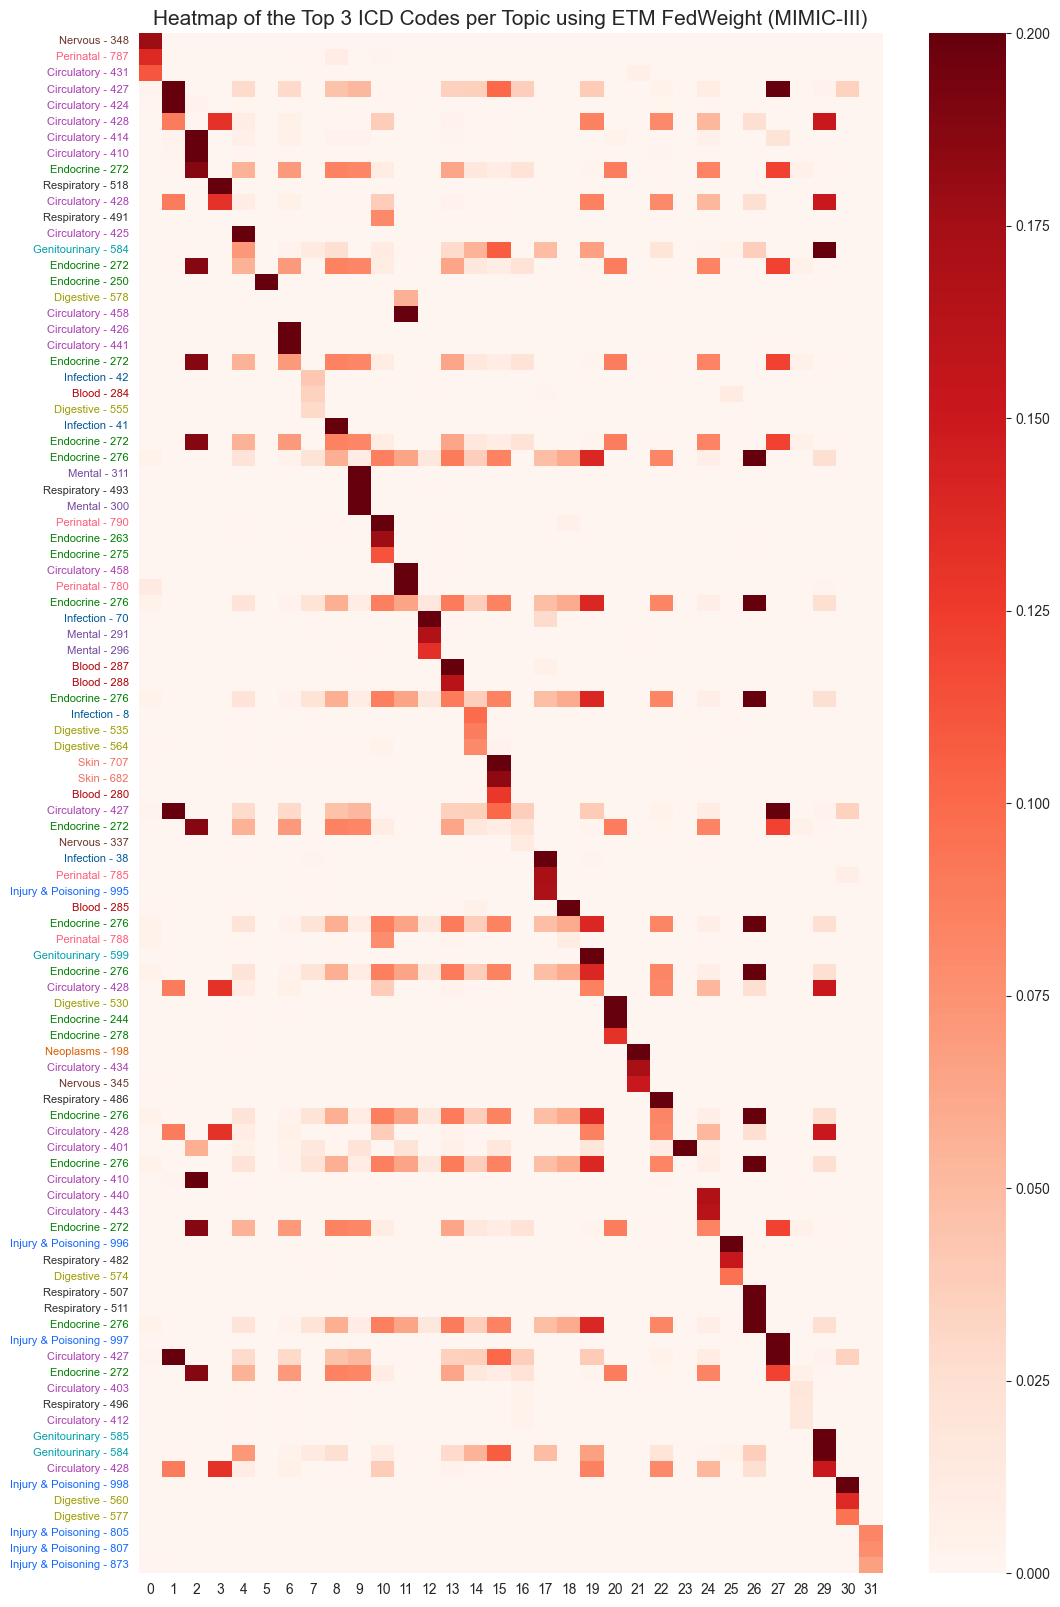

In [358]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

mimic_topic_word_distribution = weighted_mimic_client_model.get_beta()
mimic_topic_word_distribution = mimic_topic_word_distribution.data.cpu().numpy()

total_top_icd_idx = np.zeros((mimic_topic_word_distribution.shape[0], 3))  # K x 5

for topic in range(mimic_topic_word_distribution.shape[0]):
    topic_icds = mimic_topic_word_distribution[topic, :]
    top_icd_idx = np.flip(np.argsort(topic_icds))[:3]  # Top 5 ICD codes
    total_top_icd_idx[topic] = top_icd_idx

total_top_icd_idx = np.ravel(total_top_icd_idx).astype(int)

mimic_total_top_icd = mimic_topic_word_distribution[:, total_top_icd_idx]
mimic_total_top_icd = mimic_total_top_icd.T

total_top_icd_names = icd_code_names[total_top_icd_idx]
disease = [convert_icd9_to_disease(x) for x in total_top_icd_names]
disease_label = [f"{disease[i]} - {total_top_icd_names[i]}" for i in range(len(disease))]

plt.figure(figsize=(12, 20))

# Plot heatmap
plt.title("Heatmap of the Top 3 ICD Codes per Topic using ETM FedWeight (MIMIC-III)", fontsize=15)
ax = sns.heatmap(mimic_total_top_icd,
            yticklabels=disease_label,
            cmap='Reds', vmax=0.2)

ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)

y_labels = plt.gca().get_yticklabels()
for i, label in enumerate(y_labels):
    color = disease_color_map[disease[i]]
    label.set_color(color)
    

plt.show()

In [359]:
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# 
# mimic_topic_word_distribution = weighted_mimic_client_model.get_beta()
# mimic_topic_word_distribution = mimic_topic_word_distribution.data.cpu().numpy()
# 
# topic_death_mimic_top_5_most_and_least_significant_topics = np.concatenate(
#     (topic_death_mimic_top_5_most_significant_topics, topic_death_mimic_top_5_least_significant_topics)
# )
# 
# filtered_mimic_topic_word_distribution = mimic_topic_word_distribution[topic_death_mimic_top_5_most_and_least_significant_topics]
# 
# mimic_total_top_icd_idx = np.zeros((filtered_mimic_topic_word_distribution.shape[0], 3))  # K x 5
# 
# topic_death_mimic_significant_icds = []
# for topic in range(filtered_mimic_topic_word_distribution.shape[0]):
#     topic_icds = filtered_mimic_topic_word_distribution[topic, :]
#     top_icd_idx = np.flip(np.argsort(topic_icds))[:3]  # Top 5 ICD codes
#     top_icd_code_names = icd_code_names[top_icd_idx]
#     print("Topic: ", topic_death_mimic_top_5_most_and_least_significant_topics[topic], " ICD idx: ", top_icd_idx, " ICD names: ", top_icd_code_names)
#     mimic_total_top_icd_idx[topic] = top_icd_idx
#     topic_death_mimic_significant_icds.extend(top_icd_idx)
# 
# 
# topic_death_mimic_top_5_most_significant_icds = set()
# for topic in topic_death_mimic_top_5_most_significant_topics:
#     filtered_distribution = mimic_topic_word_distribution[topic, :]
#     top_icd_idx = np.flip(np.argsort(filtered_distribution))[:3]  # Top 5 ICD codes
#     print("Most significant topic: ", topic, " ICD idx: ", top_icd_idx)
#     topic_death_mimic_top_5_most_significant_icds.update(top_icd_idx)
# # 
# # topic_death_mimic_top_5_least_significant_icds = set()
# # for topic in topic_death_mimic_top_5_least_significant_topics:
# #     filtered_distribution = mimic_topic_word_distribution[topic, :]
# #     top_icd_idx = np.flip(np.argsort(filtered_distribution))[:3]  # Top 5 ICD codes
# #     print("Least significant topic: ", topic, " ICD idx: ", top_icd_idx)
# #     topic_death_mimic_top_5_least_significant_icds.update(top_icd_idx)
# # 
# # topic_death_mimic_significant_icds = topic_death_mimic_top_5_most_significant_icds.union(topic_death_mimic_top_5_least_significant_icds)
# 
# mimic_total_top_icd_idx = np.ravel(mimic_total_top_icd_idx).astype(int)
# 
# mimic_total_top_icd = filtered_mimic_topic_word_distribution[:, mimic_total_top_icd_idx]
# mimic_total_top_icd = mimic_total_top_icd.T
# 
# mimic_total_top_icd_names = icd_code_names[mimic_total_top_icd_idx]
# mimic_disease = [convert_icd9_to_disease(x) for x in mimic_total_top_icd_names]
# mimic_disease_description = [icd_descriptions_updated.get(x, "Unknown") for x in mimic_total_top_icd_names]
# mimic_disease_label = [f"{mimic_disease_description[i]} - {mimic_total_top_icd_names[i]}" for i in range(len(mimic_disease))]
# 
# plt.figure(figsize=(2.2, 7))
# 
# # Plot heatmap
# plt.title("Top 3 ICD Codes per Topic using ETM FedWeight\n(MIMIC-III)", fontsize=12)
# ax = sns.heatmap(mimic_total_top_icd,
#             yticklabels=mimic_disease_label,
#             xticklabels=topic_death_mimic_top_5_most_and_least_significant_topics,
#             cmap='Reds', vmax=0.2,
#             cbar_kws={'orientation': 'horizontal', 'pad': 0.1, 'shrink': 1.0})
# 
# ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)
# 
# y_labels = plt.gca().get_yticklabels()
# for i, label in enumerate(y_labels):
#     color = disease_color_map[mimic_disease[i]]
#     label.set_color(color)
#     
# x_labels = plt.gca().get_xticklabels()
# for label in x_labels:
#     topic = int(label.get_text())  # Extract topic number
#     if topic in topic_death_mimic_top_5_most_significant_topics:
#         label.set_color('red')  # Use red for most significant topics
#     else:
#         label.set_color('blue')  # Use blue for others
# 
# plt.xlabel("Topics")
# plt.show()

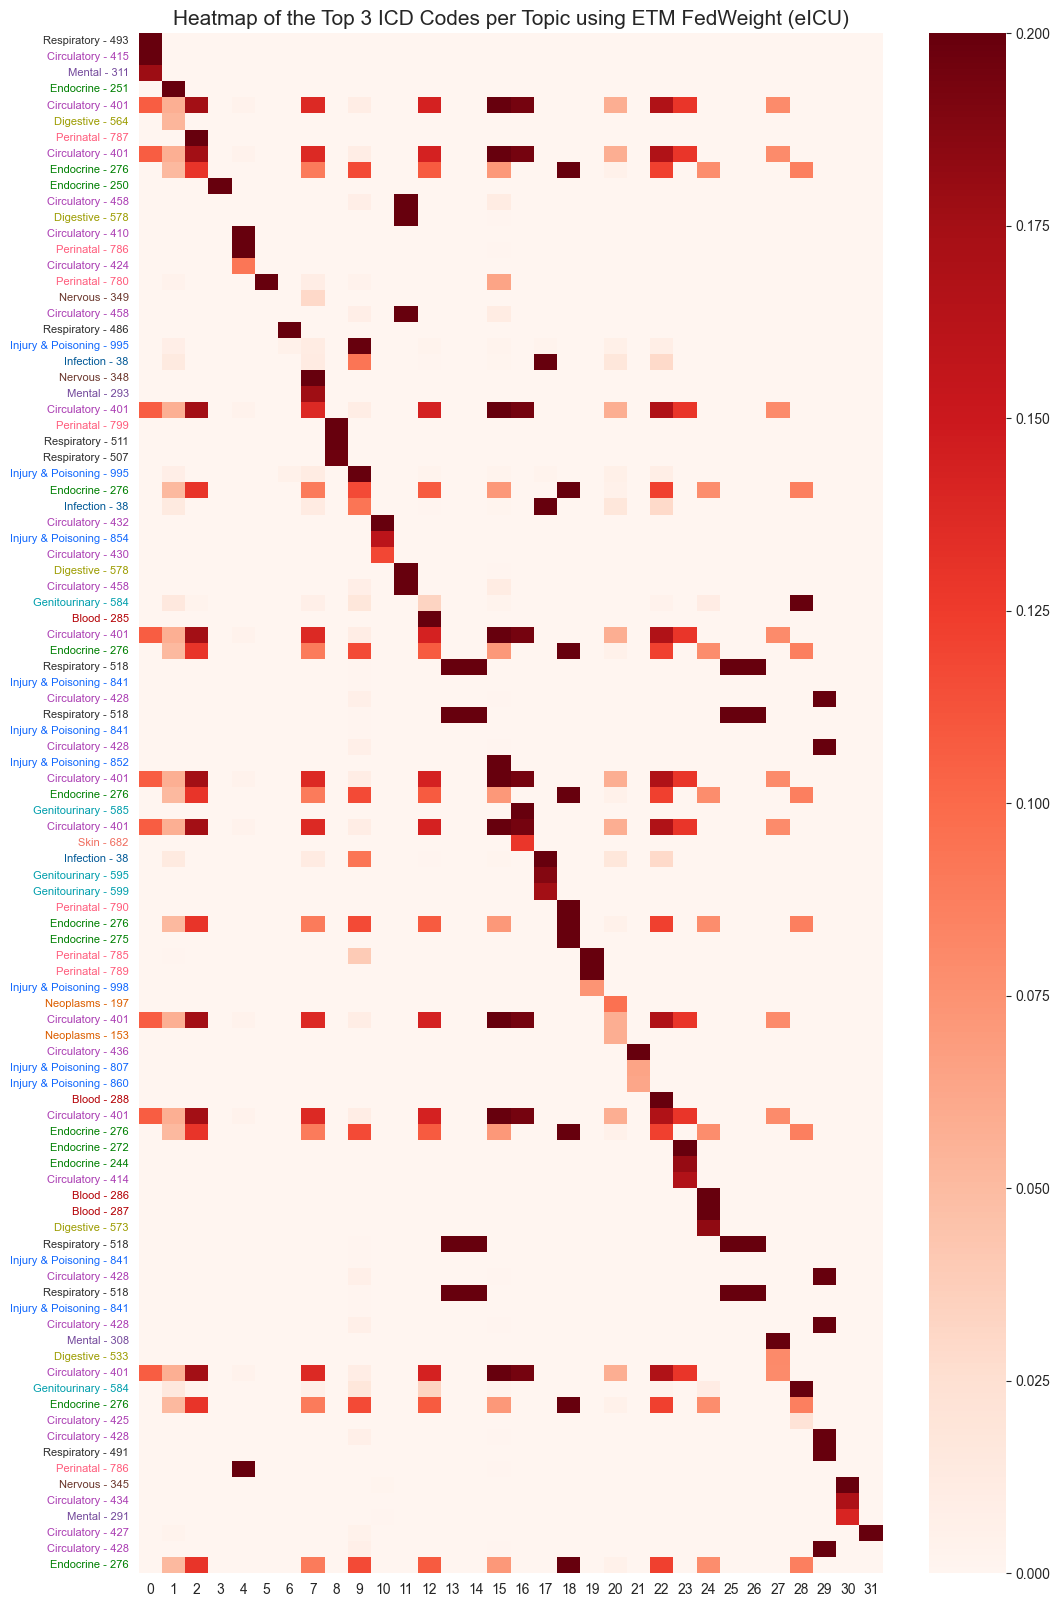

In [360]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

eicu_topic_word_distribution = weighted_eicu_client_model.get_beta()
eicu_topic_word_distribution = eicu_topic_word_distribution.data.cpu().numpy()

total_top_icd_idx = np.zeros((eicu_topic_word_distribution.shape[0], 3))  # K x 5

for topic in range(eicu_topic_word_distribution.shape[0]):
    topic_icds = eicu_topic_word_distribution[topic, :]
    top_icd_idx = np.flip(np.argsort(topic_icds))[:3]  # Top 5 ICD codes
    total_top_icd_idx[topic] = top_icd_idx

total_top_icd_idx = np.ravel(total_top_icd_idx).astype(int)

eicu_total_top_icd = eicu_topic_word_distribution[:, total_top_icd_idx]
eicu_total_top_icd = eicu_total_top_icd.T

total_top_icd_names = icd_code_names[total_top_icd_idx]
disease = [convert_icd9_to_disease(x) for x in total_top_icd_names]
disease_label = [f"{disease[i]} - {total_top_icd_names[i]}" for i in range(len(disease))]

plt.figure(figsize=(12, 20))

# Plot heatmap
plt.title("Heatmap of the Top 3 ICD Codes per Topic using ETM FedWeight (eICU)", fontsize=15)
ax = sns.heatmap(eicu_total_top_icd,
            yticklabels=disease_label,
            cmap='Reds', vmax=0.2)

ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)

y_labels = plt.gca().get_yticklabels()
for i, label in enumerate(y_labels):
    color = disease_color_map[disease[i]]
    label.set_color(color)
    

plt.show()

In [361]:
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# 
# eicu_topic_word_distribution = weighted_eicu_client_model.get_beta()
# eicu_topic_word_distribution = eicu_topic_word_distribution.data.cpu().numpy()
# 
# topic_death_eicu_top_5_most_and_least_significant_topics = np.concatenate(
#     (topic_death_eicu_top_5_most_significant_topics, topic_death_eicu_top_5_least_significant_topics)
# )
# 
# print(topic_death_eicu_top_5_most_and_least_significant_topics)
# 
# filtered_eicu_topic_word_distribution = eicu_topic_word_distribution[topic_death_eicu_top_5_most_and_least_significant_topics]
# 
# eicu_total_top_icd_idx = np.zeros((filtered_eicu_topic_word_distribution.shape[0], 3))  # K x 3
# 
# topic_death_eicu_significant_icds = []
# for topic in range(filtered_eicu_topic_word_distribution.shape[0]):
#     topic_icds = filtered_eicu_topic_word_distribution[topic, :]
#     top_icd_idx = np.flip(np.argsort(topic_icds))[:3]  # Top 3 ICD codes
#     top_icd_code_names = icd_code_names[top_icd_idx]
#     print("Topic: ", topic_death_eicu_top_5_most_and_least_significant_topics[topic], " ICD idx: ", top_icd_idx, " ICD names: ", top_icd_code_names)
#     eicu_total_top_icd_idx[topic] = top_icd_idx
#     topic_death_eicu_significant_icds.extend(top_icd_idx)
# 
# print(topic_death_eicu_significant_icds)
# topic_death_eicu_top_5_most_significant_icds = set()
# for topic in topic_death_eicu_top_5_most_significant_topics:
#     filtered_distribution = eicu_topic_word_distribution[topic, :]
#     top_icd_idx = np.flip(np.argsort(filtered_distribution))[:3]  # Top 5 ICD codes
#     print("Most significant topic: ", topic, " ICD idx: ", top_icd_idx)
#     topic_death_eicu_top_5_most_significant_icds.update(top_icd_idx)
# 
# # topic_death_eicu_top_5_least_significant_icds = set()
# # for topic in topic_death_eicu_top_5_least_significant_topics:
# #     filtered_distribution = eicu_topic_word_distribution[topic, :]
# #     top_icd_idx = np.flip(np.argsort(filtered_distribution))[:3]  # Top 5 ICD codes
# #     print("Least significant topic: ", topic, " ICD idx: ", top_icd_idx)
# #     topic_death_eicu_top_5_least_significant_icds.update(top_icd_idx)
# 
# # topic_death_eicu_significant_icds = topic_death_eicu_top_5_most_significant_icds.union(topic_death_eicu_top_5_least_significant_icds)
# 
# eicu_total_top_icd_idx = np.ravel(eicu_total_top_icd_idx).astype(int)
# 
# eicu_total_top_icd = filtered_eicu_topic_word_distribution[:, eicu_total_top_icd_idx]
# eicu_total_top_icd = eicu_total_top_icd.T
# 
# eicu_total_top_icd_names = icd_code_names[eicu_total_top_icd_idx]
# print(eicu_total_top_icd_names)
# eicu_disease = [convert_icd9_to_disease(x) for x in eicu_total_top_icd_names]
# eicu_disease_description = [icd_descriptions_updated.get(x, "Unknown") for x in eicu_total_top_icd_names]
# eicu_disease_label = [f"{eicu_disease_description[i]} - {eicu_total_top_icd_names[i]}" for i in range(len(eicu_disease))]
# 
# plt.figure(figsize=(2.2, 7))
# 
# # Plot heatmap
# plt.title("Top 3 ICD Codes per Topic using ETM FedWeight\n(eICU)", fontsize=12)
# ax = sns.heatmap(eicu_total_top_icd,
#             yticklabels=eicu_disease_label,
#             xticklabels=topic_death_eicu_top_5_most_and_least_significant_topics,
#             cmap='Reds', vmax=0.2,
#             cbar_kws={'orientation': 'horizontal', 'pad': 0.1, 'shrink': 1.0})
# 
# ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)
# 
# y_labels = plt.gca().get_yticklabels()
# for i, label in enumerate(y_labels):
#     color = disease_color_map[eicu_disease[i]]
#     label.set_color(color)
#     
# x_labels = plt.gca().get_xticklabels()
# for label in x_labels:
#     topic = int(label.get_text())  # Extract topic number
#     if topic in topic_death_eicu_top_5_most_significant_topics:
#         label.set_color('red')  # Use red for most significant topics
#     else:
#         label.set_color('blue')  # Use blue for others
# 
# plt.xlabel("Topics")
# plt.show()

In [362]:
topic_death_eicu_top_5_most_significant_topics

array([16, 31, 28, 11,  8])

[16 31 28 11  8 30 15 10  0  3]
Topic: 16 ICD idx: [472 320 551] ICD names: Index(['585', '401', '682'], dtype='object')
Topic: 31 ICD idx: [340] ICD names: Index(['427'], dtype='object')
Topic: 28 ICD idx: [471 202] ICD names: Index(['584', '276'], dtype='object')
Topic: 11 ICD idx: [465 369] ICD names: Index(['578', '458'], dtype='object')
Topic: 8 ICD idx: [660 408 405] ICD names: Index(['799', '511', '507'], dtype='object')
Topic: 30 ICD idx: [268 347 217 326] ICD names: Index(['345', '434', '291', '411'], dtype='object')
Topic: 15 ICD idx: [708 320] ICD names: Index(['852', '401'], dtype='object')
Topic: 10 ICD idx: [345 710 343 707] ICD names: Index(['432', '854', '430', '851'], dtype='object')
Topic: 0 ICD idx: [397 330 237 320 362] ICD names: Index(['493', '415', '311', '401', '451'], dtype='object')
Topic: 3 ICD idx: [177] ICD names: Index(['250'], dtype='object')
Index(['585', '401', '682', '427', '584', '276', '578', '458', '799', '511',
       '507', '345', '434', '291', '4

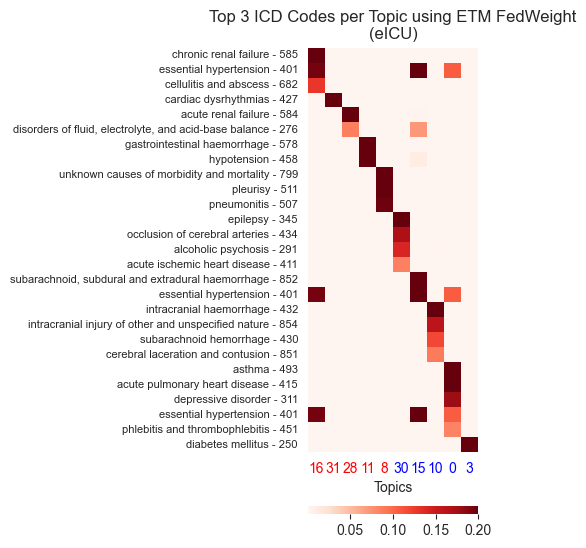

In [363]:
eicu_topic_word_distribution = weighted_eicu_client_model.get_beta()
eicu_topic_word_distribution = eicu_topic_word_distribution.data.cpu().numpy()

topic_death_eicu_top_5_most_and_least_significant_topics = np.concatenate(
    (topic_death_eicu_top_5_most_significant_topics, topic_death_eicu_top_5_least_significant_topics)
)

print(topic_death_eicu_top_5_most_and_least_significant_topics)

filtered_eicu_topic_word_distribution = eicu_topic_word_distribution[topic_death_eicu_top_5_most_and_least_significant_topics]

# Initialize list for top ICD indices
eicu_total_top_icd_idx = []

topic_death_eicu_significant_icds = []
topic_death_eicu_top_5_most_significant_icds = set()
for idx, topic in enumerate(topic_death_eicu_top_5_most_and_least_significant_topics):
# for topic in range(filtered_eicu_topic_word_distribution.shape[0]):
    topic_icds = filtered_eicu_topic_word_distribution[idx, :]
    
    # Select top ICD codes with values greater than 0.15
    top_icd_idx = np.where(topic_icds > 0.08)[0]
    
    # Sort these selected ICD codes from large to small
    sorted_top_icd_idx = top_icd_idx[np.argsort(-topic_icds[top_icd_idx])]
    
    if topic in topic_death_eicu_top_5_most_significant_topics:
        topic_death_eicu_top_5_most_significant_icds.update(sorted_top_icd_idx)
    
    # Get the corresponding ICD code names
    top_icd_code_names = icd_code_names[sorted_top_icd_idx]
    
    print(f"Topic: {topic_death_eicu_top_5_most_and_least_significant_topics[idx]} ICD idx: {sorted_top_icd_idx} ICD names: {top_icd_code_names}")
    
    eicu_total_top_icd_idx.append(sorted_top_icd_idx)
    topic_death_eicu_significant_icds.extend(sorted_top_icd_idx)


eicu_total_top_icd_idx = np.concatenate(eicu_total_top_icd_idx)
eicu_total_top_icd = filtered_eicu_topic_word_distribution[:, eicu_total_top_icd_idx]
eicu_total_top_icd = eicu_total_top_icd.T

eicu_total_top_icd_names = icd_code_names[eicu_total_top_icd_idx]
print(eicu_total_top_icd_names)
eicu_disease = [convert_icd9_to_disease(x) for x in eicu_total_top_icd_names]
eicu_disease_description = [icd_descriptions_updated.get(x, "Unknown") for x in eicu_total_top_icd_names]
eicu_disease_label = [f"{eicu_disease_description[i]} - {eicu_total_top_icd_names[i]}" for i in range(len(eicu_disease))]

plt.figure(figsize=(2.2, 7))

# Plot heatmap
plt.title("Top 3 ICD Codes per Topic using ETM FedWeight\n(eICU)", fontsize=12)
ax = sns.heatmap(eicu_total_top_icd,
            yticklabels=eicu_disease_label,
            xticklabels=topic_death_eicu_top_5_most_and_least_significant_topics,
            cmap='Reds', vmax=0.2,
            cbar_kws={'orientation': 'horizontal', 'pad': 0.1, 'shrink': 1.0})

ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)

# y_labels = plt.gca().get_yticklabels()
# for i, label in enumerate(y_labels):
#     color = disease_color_map[eicu_disease[i]]
#     label.set_color(color)
    
x_labels = plt.gca().get_xticklabels()
for label in x_labels:
    topic = int(label.get_text())  # Extract topic number
    if topic in topic_death_eicu_top_5_most_significant_topics:
        label.set_color('red')  # Use red for most significant topics
    else:
        label.set_color('blue')  # Use blue for others

plt.xlabel("Topics")
plt.show()

[17 10 25  1 19  9  6  2 20 23]
Topic: 17 ICD idx: [ 23 647 832] ICD names: Index(['38', '785', '995'], dtype='object')
Topic: 10 ICD idx: [652 190 201 202 395] ICD names: Index(['790', '263', '275', '276', '491'], dtype='object')
Topic: 25 ICD idx: [833 387 461 463] ICD names: Index(['996', '482', '574', '576'], dtype='object')
Topic: 1 ICD idx: [340 337 341] ICD names: Index(['427', '424', '428'], dtype='object')
Topic: 19 ICD idx: [486 202 341] ICD names: Index(['599', '276', '428'], dtype='object')
Topic: 9 ICD idx: [237 397 226 198] ICD names: Index(['311', '493', '300', '272'], dtype='object')
Topic: 6 ICD idx: [339 353] ICD names: Index(['426', '441'], dtype='object')
Topic: 2 ICD idx: [329 325 198 326] ICD names: Index(['414', '410', '272', '411'], dtype='object')
Topic: 20 ICD idx: [427 173 204 220 198] ICD names: Index(['530', '244', '278', '294', '272'], dtype='object')
Topic: 23 ICD idx: [320] ICD names: Index(['401'], dtype='object')
Index(['38', '785', '995', '790', '263'

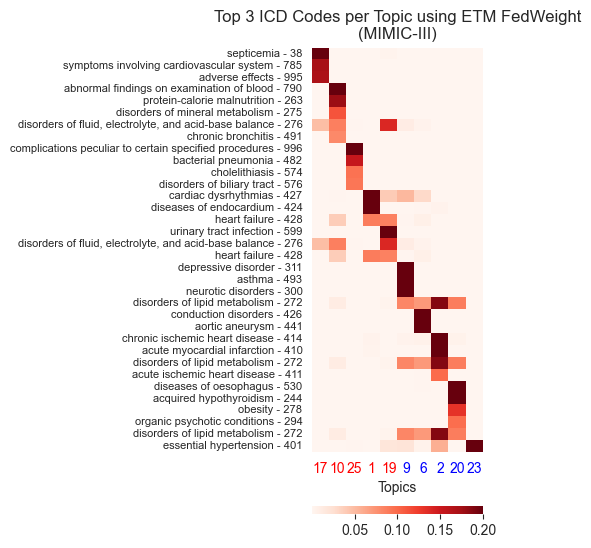

In [364]:
mimic_topic_word_distribution = weighted_mimic_client_model.get_beta()
mimic_topic_word_distribution = mimic_topic_word_distribution.data.cpu().numpy()

topic_death_mimic_top_5_most_and_least_significant_topics = np.concatenate(
    (topic_death_mimic_top_5_most_significant_topics, topic_death_mimic_top_5_least_significant_topics)
)

print(topic_death_mimic_top_5_most_and_least_significant_topics)

filtered_mimic_topic_word_distribution = mimic_topic_word_distribution[topic_death_mimic_top_5_most_and_least_significant_topics]

# Initialize list for top ICD indices
mimic_total_top_icd_idx = []

topic_death_mimic_significant_icds = []
topic_death_mimic_top_5_most_significant_icds = set()
for idx, topic in enumerate(topic_death_mimic_top_5_most_and_least_significant_topics):
# for topic in range(filtered_mimic_topic_word_distribution.shape[0]):
    topic_icds = filtered_mimic_topic_word_distribution[idx, :]
    
    # Select top ICD codes with values greater than 0.15
    top_icd_idx = np.where(topic_icds > 0.08)[0]
    
    # Sort these selected ICD codes from large to small
    sorted_top_icd_idx = top_icd_idx[np.argsort(-topic_icds[top_icd_idx])]
    
    if topic in topic_death_mimic_top_5_most_significant_topics:
        topic_death_mimic_top_5_most_significant_icds.update(sorted_top_icd_idx)
    
    # Get the corresponding ICD code names
    top_icd_code_names = icd_code_names[sorted_top_icd_idx]
    
    print(f"Topic: {topic_death_mimic_top_5_most_and_least_significant_topics[idx]} ICD idx: {sorted_top_icd_idx} ICD names: {top_icd_code_names}")
    
    mimic_total_top_icd_idx.append(sorted_top_icd_idx)
    topic_death_mimic_significant_icds.extend(sorted_top_icd_idx)


mimic_total_top_icd_idx = np.concatenate(mimic_total_top_icd_idx)
mimic_total_top_icd = filtered_mimic_topic_word_distribution[:, mimic_total_top_icd_idx]
mimic_total_top_icd = mimic_total_top_icd.T

mimic_total_top_icd_names = icd_code_names[mimic_total_top_icd_idx]
print(mimic_total_top_icd_names)
mimic_disease = [convert_icd9_to_disease(x) for x in mimic_total_top_icd_names]
mimic_disease_description = [icd_descriptions_updated.get(x, "Unknown") for x in mimic_total_top_icd_names]
mimic_disease_label = [f"{mimic_disease_description[i]} - {mimic_total_top_icd_names[i]}" for i in range(len(mimic_disease))]

plt.figure(figsize=(2.2, 7))

# Plot heatmap
plt.title("Top 3 ICD Codes per Topic using ETM FedWeight\n(MIMIC-III)", fontsize=12)
ax = sns.heatmap(mimic_total_top_icd,
            yticklabels=mimic_disease_label,
            xticklabels=topic_death_mimic_top_5_most_and_least_significant_topics,
            cmap='Reds', vmax=0.2,
            cbar_kws={'orientation': 'horizontal', 'pad': 0.1, 'shrink': 1.0})

ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)

# y_labels = plt.gca().get_yticklabels()
# for i, label in enumerate(y_labels):
#     color = disease_color_map[mimic_disease[i]]
#     label.set_color(color)
    
x_labels = plt.gca().get_xticklabels()
for label in x_labels:
    topic = int(label.get_text())  # Extract topic number
    if topic in topic_death_mimic_top_5_most_significant_topics:
        label.set_color('red')  # Use red for most significant topics
    else:
        label.set_color('blue')  # Use blue for others

plt.xlabel("Topics")
plt.show()

In [365]:
eicu_total_top_icd_idx

array([472, 320, 551, 340, 471, 202, 465, 369, 660, 408, 405, 268, 347,
       217, 326, 708, 320, 345, 710, 343, 707, 397, 330, 237, 320, 362,
       177])

In [366]:
icd_descriptions_updated

{'244': 'acquired hypothyroidism',
 '250': 'diabetes mellitus',
 '263': 'protein-calorie malnutrition',
 '272': 'disorders of lipid metabolism',
 '275': 'disorders of mineral metabolism',
 '276': 'disorders of fluid, electrolyte, and acid-base balance',
 '278': 'obesity',
 '291': 'alcoholic psychosis',
 '294': 'organic psychotic conditions',
 '300': 'neurotic disorders',
 '311': 'depressive disorder',
 '345': 'epilepsy',
 '38': 'septicemia',
 '401': 'essential hypertension',
 '410': 'acute myocardial infarction',
 '411': 'acute ischemic heart disease',
 '414': 'chronic ischemic heart disease',
 '415': 'acute pulmonary heart disease',
 '424': 'diseases of endocardium',
 '426': 'conduction disorders',
 '427': 'cardiac dysrhythmias',
 '428': 'heart failure',
 '430': 'subarachnoid hemorrhage',
 '432': 'intracranial haemorrhage',
 '434': 'occlusion of cerebral arteries',
 '441': 'aortic aneurysm',
 '451': 'phlebitis and thrombophlebitis',
 '458': 'hypotension',
 '482': 'bacterial pneumonia'

In [367]:
set([icd_code_names[top_icd_idx] for top_icd_idx in topic_death_mimic_significant_icds]).union(set([icd_code_names[top_icd_idx] for top_icd_idx in topic_death_eicu_significant_icds]))

{'244',
 '250',
 '263',
 '272',
 '275',
 '276',
 '278',
 '291',
 '294',
 '300',
 '311',
 '345',
 '38',
 '401',
 '410',
 '411',
 '414',
 '415',
 '424',
 '426',
 '427',
 '428',
 '430',
 '432',
 '434',
 '441',
 '451',
 '458',
 '482',
 '491',
 '493',
 '507',
 '511',
 '530',
 '574',
 '576',
 '578',
 '584',
 '585',
 '599',
 '682',
 '785',
 '790',
 '799',
 '851',
 '852',
 '854',
 '995',
 '996'}

In [368]:
eicu_total_top_icd_idx

array([472, 320, 551, 340, 471, 202, 465, 369, 660, 408, 405, 268, 347,
       217, 326, 708, 320, 345, 710, 343, 707, 397, 330, 237, 320, 362,
       177])

In [369]:
filtered_eicu_topic_word_distribution.shape

(10, 837)

In [370]:
eicu_total_top_icd_idx.shape

(27,)

In [371]:
eicu_topic_word_distribution.shape

(32, 837)

In [372]:
from sklearn.model_selection import train_test_split

eicu_hospital_data = icd_data[icd_data["hospitalid"] == 1001]
eicu_train_data, _ = train_test_split(eicu_hospital_data, test_size=0.2, random_state=42)

eicu_train_data_np = eicu_train_data.to_numpy()
eicu_train_readmit_patients_row_ids = np.where(eicu_train_data_np[:, 3] == 1)[0]

# Filter all patients who were readmitted, check the correlation between their ICD and death
eicu_x_death_train = eicu_train_data.iloc[eicu_train_readmit_patients_row_ids, 4:].to_numpy()
eicu_y_death_train = eicu_train_data.iloc[eicu_train_readmit_patients_row_ids, 2].to_numpy()

mimic_hospital_data = icd_data[icd_data["hospitalid"] == 2001]
mimic_train_data, _ = train_test_split(mimic_hospital_data, test_size=0.2, random_state=42)

mimic_train_data_np = mimic_train_data.to_numpy()
mimic_train_readmit_patients_row_ids = np.where(mimic_train_data_np[:, 3] == 1)[0]

# Filter all patients who were readmitted, check the correlation between their ICD and death
mimic_x_death_train = mimic_train_data.iloc[mimic_train_readmit_patients_row_ids, 4:].to_numpy()
mimic_y_death_train = mimic_train_data.iloc[mimic_train_readmit_patients_row_ids, 2].to_numpy()

In [373]:
from scipy.stats import fisher_exact

topic_death_mimic_ground_truth_p_values = []
topic_death_mimic_ground_truth_deseases = []
topic_death_mimic_ground_truth_desease_labels = []
topic_death_mimic_ground_truth_most_significance_with_death = []

topic_death_eicu_ground_truth_p_values = []
topic_death_eicu_ground_truth_deseases = []
topic_death_eicu_ground_truth_desease_labels = []
topic_death_eicu_ground_truth_most_significance_with_death = []

for icd_code_idx in topic_death_mimic_significant_icds:
    X_mimic_train_icd = mimic_x_death_train[:, icd_code_idx]
    X_mimic_train_icd_death = X_mimic_train_icd[mimic_y_death_train == 1]
    X_mimic_train_icd_alive = X_mimic_train_icd[mimic_y_death_train == 0]
    
    icd_code_name = icd_code_names[icd_code_idx]
    
    mimic_disease = convert_icd9_to_disease(icd_code_name)
    mimic_disease_description = icd_descriptions_updated.get(icd_code_name, "Unknown")
    mimic_disease_label = mimic_disease_description + " - " + icd_code_name

    print("[MIMIC] ICD : ", mimic_disease_label, " Death : ", X_mimic_train_icd_death.shape, " Alive : ", X_mimic_train_icd_alive.shape)

    presence_death = (X_mimic_train_icd_death > 0).sum()
    absence_death = (X_mimic_train_icd_death == 0).sum()
    presence_alive = (X_mimic_train_icd_alive > 0).sum()
    absence_alive = (X_mimic_train_icd_alive == 0).sum()
    
    contingency_table = [[presence_death, presence_alive],
                         [absence_death, absence_alive]]
    
    # Perform Fisher's Exact Test
    _, mimic_p_value = fisher_exact(contingency_table, alternative='greater')
    neg_log_mimic_p_value = -np.log10(mimic_p_value)
    topic_death_mimic_ground_truth_p_values.append(neg_log_mimic_p_value)
    topic_death_mimic_ground_truth_deseases.append(mimic_disease)
    topic_death_mimic_ground_truth_desease_labels.append(mimic_disease_label)
    
    if icd_code_idx in topic_death_mimic_top_5_most_significant_icds:
        topic_death_mimic_ground_truth_most_significance_with_death.append(1)
    else:
        topic_death_mimic_ground_truth_most_significance_with_death.append(0)

for icd_code_idx in topic_death_eicu_significant_icds:
    
    X_eicu_train_icd = eicu_x_death_train[:, icd_code_idx]
    X_eicu_train_icd_death = X_eicu_train_icd[eicu_y_death_train == 1]
    X_eicu_train_icd_alive = X_eicu_train_icd[eicu_y_death_train == 0]
    
    icd_code_name = icd_code_names[icd_code_idx]
    
    eicu_disease = convert_icd9_to_disease(icd_code_name)
    eicu_disease_description = icd_descriptions_updated.get(icd_code_name, "Unknown")
    eicu_disease_label = eicu_disease_description + " - " + icd_code_name

    print("[eICU] ICD : ", eicu_disease_label, " Death : ", X_eicu_train_icd_death.shape, " Alive : ", X_eicu_train_icd_alive.shape)

    presence_death = (X_eicu_train_icd_death > 0).sum()
    absence_death = (X_eicu_train_icd_death == 0).sum()
    presence_alive = (X_eicu_train_icd_alive > 0).sum()
    absence_alive = (X_eicu_train_icd_alive == 0).sum()
    
    contingency_table = [[presence_death, presence_alive],
                         [absence_death, absence_alive]]
    
    # Perform Fisher's Exact Test
    _, eicu_p_value = fisher_exact(contingency_table, alternative='greater')
    neg_log_eicu_p_value = -np.log10(eicu_p_value)
    topic_death_eicu_ground_truth_p_values.append(neg_log_eicu_p_value)
    topic_death_eicu_ground_truth_deseases.append(eicu_disease)
    topic_death_eicu_ground_truth_desease_labels.append(eicu_disease_label)
    
    if icd_code_idx in topic_death_eicu_top_5_most_significant_icds:
        topic_death_eicu_ground_truth_most_significance_with_death.append(1)
    else:
        topic_death_eicu_ground_truth_most_significance_with_death.append(0)

[MIMIC] ICD :  septicemia - 38  Death :  (1197,)  Alive :  (4649,)
[MIMIC] ICD :  symptoms involving cardiovascular system - 785  Death :  (1197,)  Alive :  (4649,)
[MIMIC] ICD :  adverse effects - 995  Death :  (1197,)  Alive :  (4649,)
[MIMIC] ICD :  abnormal findings on examination of blood - 790  Death :  (1197,)  Alive :  (4649,)
[MIMIC] ICD :  protein-calorie malnutrition - 263  Death :  (1197,)  Alive :  (4649,)
[MIMIC] ICD :  disorders of mineral metabolism - 275  Death :  (1197,)  Alive :  (4649,)
[MIMIC] ICD :  disorders of fluid, electrolyte, and acid-base balance - 276  Death :  (1197,)  Alive :  (4649,)
[MIMIC] ICD :  chronic bronchitis - 491  Death :  (1197,)  Alive :  (4649,)
[MIMIC] ICD :  complications peculiar to certain specified procedures - 996  Death :  (1197,)  Alive :  (4649,)
[MIMIC] ICD :  bacterial pneumonia - 482  Death :  (1197,)  Alive :  (4649,)
[MIMIC] ICD :  cholelithiasis - 574  Death :  (1197,)  Alive :  (4649,)
[MIMIC] ICD :  disorders of biliary tra

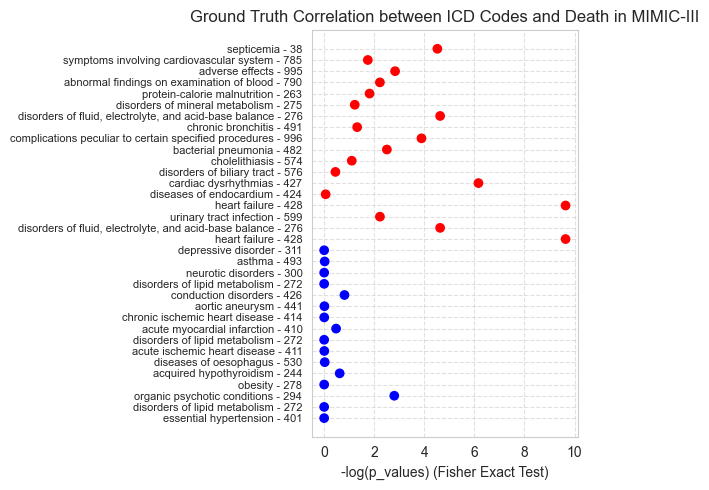

In [374]:
import matplotlib.pyplot as plt
import numpy as np

colors = ['red' if i == 1 else 'blue' for i in topic_death_mimic_ground_truth_most_significance_with_death]

# Create scatter plot
plt.figure(figsize=(6, 5))
plt.scatter(topic_death_mimic_ground_truth_p_values, range(len(topic_death_mimic_ground_truth_p_values)), c=colors)

# Add labels and title
plt.yticks(range(len(topic_death_mimic_ground_truth_desease_labels)), 
           topic_death_mimic_ground_truth_desease_labels, ha='right', fontsize=8)
plt.xlabel('-log(p_values) (Fisher Exact Test)', fontsize=10)
plt.title('Ground Truth Correlation between ICD Codes and Death in MIMIC-III', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# y_labels = plt.gca().get_yticklabels()
# print(y_labels)
# for i, label in enumerate(y_labels):
#     color = disease_color_map[topic_death_mimic_ground_truth_deseases[i]]
#     label.set_color(color)

# Show plot
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()


In [375]:
topic_death_mimic_ground_truth_desease_labels

['septicemia - 38',
 'symptoms involving cardiovascular system - 785',
 'adverse effects - 995',
 'abnormal findings on examination of blood - 790',
 'protein-calorie malnutrition - 263',
 'disorders of mineral metabolism - 275',
 'disorders of fluid, electrolyte, and acid-base balance - 276',
 'chronic bronchitis - 491',
 'complications peculiar to certain specified procedures - 996',
 'bacterial pneumonia - 482',
 'cholelithiasis - 574',
 'disorders of biliary tract - 576',
 'cardiac dysrhythmias - 427',
 'diseases of endocardium - 424',
 'heart failure - 428',
 'urinary tract infection - 599',
 'disorders of fluid, electrolyte, and acid-base balance - 276',
 'heart failure - 428',
 'depressive disorder - 311',
 'asthma - 493',
 'neurotic disorders - 300',
 'disorders of lipid metabolism - 272',
 'conduction disorders - 426',
 'aortic aneurysm - 441',
 'chronic ischemic heart disease - 414',
 'acute myocardial infarction - 410',
 'disorders of lipid metabolism - 272',
 'acute ischemi

In [376]:
topic_death_mimic_ground_truth_p_values

[4.5211521611698045,
 1.7432683366303572,
 2.832293075003886,
 2.2264725542278545,
 1.8132245197955248,
 1.2217511762082498,
 4.630977414017435,
 1.3178695838880732,
 3.886269879711247,
 2.504840456348179,
 1.1024972736217025,
 0.45025639138800905,
 6.161789504854704,
 0.058775966017203654,
 9.640675824024235,
 2.2279380439039898,
 4.630977414017435,
 9.640675824024235,
 2.5342088444583047e-05,
 0.02046944119852997,
 0.0011031202744696419,
 1.4716056624544379e-10,
 0.8113121548868286,
 0.010118737815493717,
 0.0029835790734698297,
 0.47580152540129234,
 1.4716056624544379e-10,
 0.005886782752606004,
 0.023175508432163733,
 0.6194594457870733,
 0.001059212170465378,
 2.800254781553319,
 1.4716056624544379e-10,
 7.0451018177261425e-06]

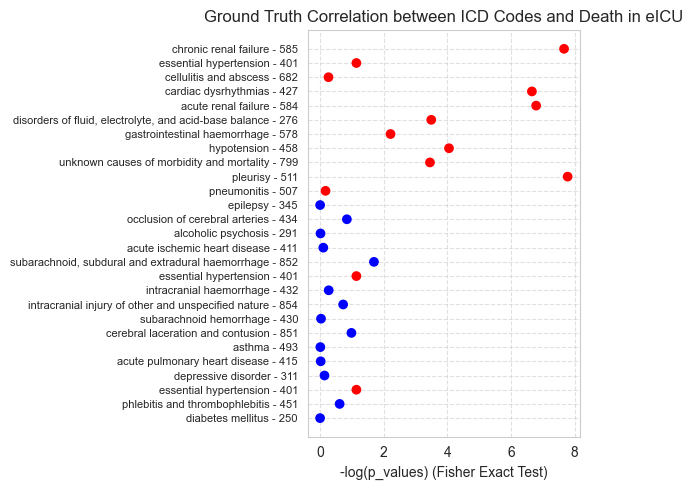

In [377]:
import matplotlib.pyplot as plt
import numpy as np

colors = ['red' if i == 1 else 'blue' for i in topic_death_eicu_ground_truth_most_significance_with_death]

# Create scatter plot
plt.figure(figsize=(6, 5))
plt.scatter(topic_death_eicu_ground_truth_p_values, range(len(topic_death_eicu_ground_truth_p_values)), c=colors)

# Add labels and title
plt.yticks(range(len(topic_death_eicu_ground_truth_desease_labels)), 
           topic_death_eicu_ground_truth_desease_labels, ha='right', fontsize=8)
plt.xlabel('-log(p_values) (Fisher Exact Test)', fontsize=10)
plt.title('Ground Truth Correlation between ICD Codes and Death in eICU', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# y_labels = plt.gca().get_yticklabels()
# print(y_labels)
# for i, label in enumerate(y_labels):
#     color = disease_color_map[topic_death_eicu_ground_truth_deseases[i]]
#     label.set_color(color)

# Show plot
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()


In [378]:
topic_death_eicu_ground_truth_most_significance_with_death

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0]

In [379]:
topic_death_eicu_top_5_most_significant_icds

{202, 320, 340, 369, 405, 408, 465, 471, 472, 551, 660}